# TEDTALK ANALYSIS - Final DL Project - 2017

## Data description

TED-LIUM Corpus

This is the TED-LIUM corpus release 2, 
licensed under Creative Commons BY-NC-ND 3.0 (http://creativecommons.org/licenses/by-nc-nd/3.0/deed.en). 

All talks and text are property of TED Conferences LLC. 

--- 

The TED-LIUM corpus was made from audio talks and their transcriptions available on the TED website. We have prepared and filtered these data in order to train acoustic models to participate to the International Workshop on Spoken Language Translation 2011 (the LIUM English/French SLT system reached the first rank in the SLT task). 

More details are given in this paper: 

A. Rousseau, P. Deléglise, and Y. Estève, "Enhancing the TED-LIUM Corpus with Selected Data for Language Modeling and More TED Talks",
in Proceedings of the Ninth International Conference on Language Resources and Evaluation (LREC’14), May 2014.

--- 

Contents: 

- 1495 audio talks in NIST sphere format (SPH) 
- 1495 transcripts in STM format 
- Dictionary with pronunciation (159848 entries) 
- Selected monolingual data for language modeling from WMT12 publicly available corpora



In [17]:
import requests
from ipywidgets import Image
Image(value=requests.get('https://i.elitestatic.com/content/uploads/2017/05/08083847/couple-talks-about-rape-ted-talk.jpg').content)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [63]:
import numpy as np
import pandas as pd
import glob
from texttable import Texttable

from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.text import text_to_word_sequence, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Flatten, LSTM , concatenate, Dense, Dropout, Activation,Conv1D, GlobalMaxPooling1D

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from time import time
from pprint import pprint

%matplotlib inline


# Cleaning & Preprocessing text data

Since, I am given only the text data of Tedtalk and no other information, which means there is no target variable present. However, the tendency of the project is to have a supervised learning model, I'm interested in defining the explanatory variables for the context of Tedtalk speech. And in this case, the classification is whether the speech is from "male" or "female" voice.

In [64]:
# female = pd.DataFrame
y = []
y_test = []

def preprocess(df, tag='train'):
    df   = df.drop(df.columns[[0, 1]], axis=1)
    str_ = ""
    str_ = df.columns[0].replace('female>', '').replace('male>', '')
    df   = df.rename(index=str, columns={df.columns[0]: "sentences"})# rename column
    
    #supervised labels male or female
    female = df['sentences'].str.contains('female>')
    male = df['sentences'].str.contains('male>')
    if tag == 'train':
        if female[0] == True:
            y.append(0) #female
        else:
            y.append(1) #male
    else:
        if female[0] == True:
            y_test.append(0) #female
        else:
            y_test.append(1) #male
        
    #truncate redundant tag word
    df['sentences'] = df['sentences'].str.replace('female>', '') # truncate female>
    df['sentences'] = df['sentences'].str.replace('male>', '') # truncate male>
    pd.options.display.max_colwidth = 400
    df['col1'] = 'A' # set a random name for column
    df = df.groupby('col1')['sentences'].apply(' '.join).reset_index()
    return str_ + df.drop(labels='col1',axis=1).loc[0][0]

# Load all tedtalk transcripts

In [65]:
path = 'TedTalk/train/stm' 
allFiles = glob.glob(path + "/*.stm")
frame = pd.DataFrame()
X = []
X_test = []
for i,file_ in enumerate(allFiles):
    df = pd.read_csv(file_)
    try:
        content_extracted = preprocess(df, tag='train')
        X.append(content_extracted)
    except:
        pass

path = 'TedTalk/test/stm' 
allFiles1 = glob.glob(path + "/*.stm")
for i,file_ in enumerate(allFiles1):
    df1 = pd.read_csv(file_)
    try:
        content_extracted = preprocess(df1, tag='test')
        X_test.append(content_extracted)
    except:
        pass

In [66]:
len(y)

1492

In [67]:
print(len(allFiles))

1495


In [68]:
len(X)

1492

In [69]:
y[:5]

[0, 0, 1, 1, 0]

In [70]:
X[0]

" today because of i first learned that my son had been in the world trade center on the morning of september eleventh two thousand and one  we didn 't know if he had perished yet until thirty six hours later at the time  we knew that it was political  we were afraid of what our country was going to do in the name of our son my husband orlando and i  and our family and when i saw it and yet through the shock  the terrible shock and the terrible  explosion in our lives literally  we were not vengeful  on six counts of conspiracy to commit terrorism  and the u s government called for a death penalty for him if convicted  my husband and i spoke out  in opposition to that publicly through that and through human rights  groups we were brought together with several other victims families when i saw aicha in the media  coming over when her son was indicted and i thought what a brave woman someday i want to meet that woman when i 'm stronger i was still in deep grief i knew i didn 't have the 

# Baseline

In [71]:
def prediction_summary(estimator, X, y):
    p = estimator.predict(X)
    correct_predictions = sum(p == y)
    incorrect_predictions = len(y) - correct_predictions
    
    # set up confusion matrix table
    label_list = [0, 1] 
    cm = confusion_matrix(y, list(p), labels=label_list)
    y1 = [i for i in y if i == 0]
    
    t = Texttable()
    t.set_cols_align(["c", "l"])
#     t.set_chars(['_', '', '', '='])
    t.add_rows([['Data Outputs','Value'],
                ['    # of correct predictions: ', str(correct_predictions)],
                ['  # of incorrect predictions: ', str(incorrect_predictions)] ,
                ['                    Accuracy: ', str(100.0 * correct_predictions / (correct_predictions + incorrect_predictions))],
                ["  Total actual female labels:", len(y1)],
                ["    Total actual male labels:", len(y) - len(y1)],
                ['              Labels in data:', label_list],
                ['            Confusion matrix', 'Columns: Predicted labels'],
                ['         Rows: actual labels', cm ]])
    t.set_cols_align(array=[0,"r"])
    t.set_cols_align(array=[1,"l"])
    print (t.draw())


## Bag of words + TfidfTransform classifier

* $ \text{tf-idf(t,d)}=\text{tf(t,d)} \times \text{idf(t)}. $


In [72]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert a collection of text documents to a matrix of token counts
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(x_train)

#Transform a count matrix to a normalized tf-idf representation
tf_transformer = TfidfTransformer(use_idf=False)
X_train_tf = tf_transformer.fit_transform(X_train_counts)

print(len(x_train),len(y_train))
clf = GaussianNB().fit(X=X_train_tf.toarray(), y=y_train)
X_new_counts = count_vect.transform(x_train)

X_new_tfidf = tf_transformer.transform(X_new_counts)
predictions = clf.predict(X_new_tfidf.toarray())

correct_predictions = sum(predictions == y_train)
incorrect_predictions = len(y_train) - correct_predictions  
print('# of correct predictions: ' + str(correct_predictions))
print('# of incorrect predictions: ' + str(incorrect_predictions))
print('Percent correct: ' + str(100.0 * correct_predictions / (correct_predictions + incorrect_predictions)))


1193 1193
# of correct predictions: 1189
# of incorrect predictions: 4
Percent correct: 99.6647108131


In [73]:
prediction_summary(clf, X_new_tfidf.toarray(), y_train)

+--------------------------------+---------------------------+
|          Data Outputs          |           Value           |
+================================+===========================+
|     # of correct predictions:  | 1189                      |
+--------------------------------+---------------------------+
|   # of incorrect predictions:  | 4                         |
+--------------------------------+---------------------------+
|                     Accuracy:  | 99.665                    |
+--------------------------------+---------------------------+
|   Total actual female labels:  | 392                       |
+--------------------------------+---------------------------+
|     Total actual male labels:  | 801                       |
+--------------------------------+---------------------------+
|               Labels in data:  | [0, 1]                    |
+--------------------------------+---------------------------+
|             Confusion matrix   | Columns: Predicted l

## MultinomialNB

In [74]:
# Naive Bayes classifier is a general term which refers to conditional independence of each of the features in the model, 
# while Multinomial Naive Bayes classifier is a specific instance of a Naive Bayes classifier 
# which uses a multinomial distribution for each of the features.
# Naive Bayes classification is the best suited for this kind of text analysis and brings the most 
# favorable results. 
# It considers word occurrence in a single document
from sklearn.naive_bayes import MultinomialNB

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# clean data: remove empty row
x_train = [x for x in x_train if x is not None]
x_test = [x for x in x_test if x is not None]

# feature extraction
count_vect = CountVectorizer()
count_vect.fit(x_train)

# turns the text into a sparse matrix
x_train_counts = count_vect.transform(x_train)

# train with MultinomialNB
nb = MultinomialNB()
nb.fit(x_train_counts, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


An example of tranformed x_train 


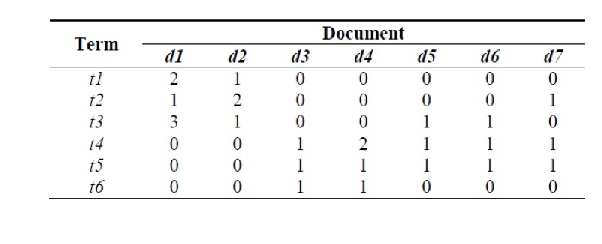

In [75]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(num=None, figsize=(7,8), dpi=100, facecolor='w', edgecolor='k')
img = mpimg.imread('transform_text_data')
plt.imshow(img)
plt.axis('off')
print('\nAn example of tranformed x_train ')
plt.show()

## Evaluate test data

In [76]:
prediction_summary(nb, count_vect.transform(x_test), y_test)

+--------------------------------+---------------------------+
|          Data Outputs          |           Value           |
+================================+===========================+
|     # of correct predictions:  | 357                       |
+--------------------------------+---------------------------+
|   # of incorrect predictions:  | 136                       |
+--------------------------------+---------------------------+
|                     Accuracy:  | 72.414                    |
+--------------------------------+---------------------------+
|   Total actual female labels:  | 152                       |
+--------------------------------+---------------------------+
|     Total actual male labels:  | 341                       |
+--------------------------------+---------------------------+
|               Labels in data:  | [0, 1]                    |
+--------------------------------+---------------------------+
|             Confusion matrix   | Columns: Predicted l

## SVM

In [77]:
count_vect = CountVectorizer()
count_vect.fit(x_train)

svm_clf = SGDClassifier()
svm_clf.fit(count_vect.transform(x_train), y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [78]:
prediction_summary(svm_clf, count_vect.transform(x_test), y_test)

+--------------------------------+---------------------------+
|          Data Outputs          |           Value           |
+================================+===========================+
|     # of correct predictions:  | 292                       |
+--------------------------------+---------------------------+
|   # of incorrect predictions:  | 201                       |
+--------------------------------+---------------------------+
|                     Accuracy:  | 59.229                    |
+--------------------------------+---------------------------+
|   Total actual female labels:  | 152                       |
+--------------------------------+---------------------------+
|     Total actual male labels:  | 341                       |
+--------------------------------+---------------------------+
|               Labels in data:  | [0, 1]                    |
+--------------------------------+---------------------------+
|             Confusion matrix   | Columns: Predicted l

In [87]:
p = Pipeline(steps=[('counts', CountVectorizer(ngram_range=(1, 2))),
                ('feature_selection', SelectKBest(chi2, k='10000')),
                ('multinomialnb', MultinomialNB())])

p.fit(x_train, y_train)

Pipeline(steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        str...i2 at 0x125320d08>)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

## Pipeline + Feature Selection

In [88]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# p = Pipeline(steps=[('counts', CountVectorizer(ngram_range=(1, 2))),
#                     ('feature_selection', SelectKBest(chi2, k=10000)), # Select features according to the k highest scores.
#                     ('tfidf', TfidfTransformer()),
#                     ('clf', SGDClassifier())])
# p = Pipeline(steps=[('counts', CountVectorizer()),
#                 ('feature_selection', SelectKBest(chi2, k='5000')),
#                 ('multinomialnb', MultinomialNB())])
parameters = {
    'counts__max_df': (0.5, 0.75,1.0),
    'counts__min_df': (0,1,2),
#    'counts__token_pattern': ('(?u)\b\w\w+\b', '(?u)\b\w\w+\b'),
    'counts__lowercase' : (True, False),
    'counts__ngram_range': ((1,1), (1,2)),
#    'feature_selection__k': (1000, 10000, 100000)

    }
# p.fit(x_train, y_train)
grid_search = GridSearchCV(p, parameters, n_jobs=-1, verbose=1)

grid_search.fit(x_train, y_train)

# print("Best score: %0.3f" % grid_search.best_score_)
# print("Best parameters set:")
# best_parameters = grid_search.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))
# print("Performing grid search...")
# print("pipeline:", [name for name, _ in p.steps])
# print("parameters:")
# pprint(parameters)
# t0 = time()
# grid_search.fit(x_train, y_train)
# print("done in %0.3fs" % (time() - t0))
# print()

# print("Best score: %0.3f" % grid_search.best_score_)
# print("Best parameters set:")
# best_parameters = grid_search.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#     print("\t%s: %r" % (param_name, best_parametders[param_name]))

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  2.6min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        str...i2 at 0x125320d08>)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'counts__max_df': (0.5, 0.75, 1.0), 'counts__min_df': (0, 1, 2), 'counts__lowercase': (True, False), 'counts__ngram_range': ((1, 1), (1, 2))},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [89]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.715
Best parameters set:
	counts__lowercase: True
	counts__max_df: 1.0
	counts__min_df: 2
	counts__ngram_range: (1, 2)


In [91]:
grid_search.best_estimator_

Pipeline(steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        str...i2 at 0x125320d08>)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

## Cross validate pipeline 

In [92]:
scores = cross_val_score(p, x_test, y_test, cv=20)
print("scores:",list(scores))
print("mean  :",scores.mean())

scores: [0.69230769230769229, 0.68000000000000005, 0.68000000000000005, 0.64000000000000001, 0.71999999999999997, 0.76000000000000001, 0.68000000000000005, 0.76000000000000001, 0.68000000000000005, 0.68000000000000005, 0.71999999999999997, 0.71999999999999997, 0.70833333333333337, 0.625, 0.79166666666666663, 0.75, 0.70833333333333337, 0.66666666666666663, 0.75, 0.75]
mean  : 0.708115384615


In [ ]:
grid_search.best_estimator_

In [ ]:
len(max(X))

## Checking Imbalance

0     491
1    1001
dtype: int64


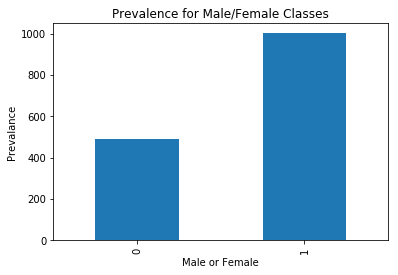

In [12]:
import pandas as pd

s = pd.Series(y)
print(s.value_counts().sort_index())
axes = s.value_counts().sort_index().plot(kind='bar')
axes.set_xlabel('Male or Female')
axes.set_ylabel('Prevalance')
axes.set_title('Prevalence for Male/Female Classes')

# Preparing the text data

In [13]:
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 2000
EMBEDDING_DIM = 50
hidden_dims = 250
VALIDATION_SPLIT = 0.2

## Tokenize training set

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(y))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


/Users/Tai/anaconda3/envs/dl/lib/python3.6/site-packages/keras/preprocessing/text.py:89: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 39753 unique tokens.
Shape of data tensor: (1492, 2000)
Shape of label tensor: (1492, 2)


In [15]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_test = data[-nb_validation_samples:]
y_test = labels[-nb_validation_samples:]


## Preparing embedding layers

In [16]:
import os
BASE_DIR = ''
GLOVE_DIR = BASE_DIR + 'glove.6B/'
TEXT_DATA_DIR = BASE_DIR + '/20_newsgroup/'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [17]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = word_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## Build DL model

In [18]:
from keras.layers import Input, Embedding, LSTM, Dense, Conv1D, Flatten, MaxPooling1D, MaxPool2D
from keras.models import Model

def cnn_model():
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(128, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(35)(x)  # global max pooling
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(2, activation='softmax')(x)
    
    model = Model(sequence_input, preds)
    return model
# model_test.summary()

In [19]:
cnn_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2000, 50)          1987700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1996, 128)         32128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 399, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 395, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 79, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 75, 128)           82048     
__________

In [20]:
# Setting the class weight as a methodology to handle imbalance class
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
class_weight

array([ 1.51934827,  0.74525475])

# Overfitting model

In [21]:
from keras.metrics import categorical_accuracy,sparse_categorical_accuracy,top_k_categorical_accuracy,binary_accuracy


model0 = cnn_model()
model0.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[top_k_categorical_accuracy])
model0.fit(x_train[:5], y_train[:5], validation_split = .1,
               epochs=10, batch_size=64, class_weight=class_weight)


Train on 4 samples, validate on 1 samples
Epoch 1/10
4/4 [==============================] - 0s - loss: 1.0603 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/10
4/4 [==============================] - 0s - loss: 12.0886 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 0s - loss: 12.0886 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 0s - loss: 12.0886 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 0s - loss: 12.0886 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_top_k_categorical_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 0s - loss: 12.0886 - top_k_categorical_accuracy: 1.0000 - v

## Metrics test

In [30]:
metrics = ['acc', binary_accuracy, categorical_accuracy, sparse_categorical_accuracy, top_k_categorical_accuracy]
def test_metric(metrics):
    acc = []
    models = []
    for metric in metrics:
        model = cnn_model()
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[metric])
        model.fit(x_train, y_train, validation_split = .2,
                       epochs=10, batch_size=64, class_weight=class_weight)
        models.append(model)
        scores = model.evaluate(x_test,y_test)
        acc.append([metric, scores])
        print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    return acc, models

In [31]:
acc_list, model_list = test_metric(metrics)

Train on 955 samples, validate on 239 samples
Epoch 1/10
955/955 [==============================] - 12s - loss: 4.7781 - acc: 0.6618 - val_loss: 5.3365 - val_acc: 0.6611
Epoch 2/10
955/955 [==============================] - 11s - loss: 5.0701 - acc: 0.6702 - val_loss: 5.3369 - val_acc: 0.6611
Epoch 3/10
955/955 [==============================] - 12s - loss: 5.0659 - acc: 0.6733 - val_loss: 5.5325 - val_acc: 0.6485
Epoch 4/10
955/955 [==============================] - 12s - loss: 5.0612 - acc: 0.6733 - val_loss: 5.3390 - val_acc: 0.6653
Epoch 5/10
955/955 [==============================] - 12s - loss: 5.0494 - acc: 0.6754 - val_loss: 5.3381 - val_acc: 0.6653
Epoch 6/10
955/955 [==============================] - 12s - loss: 5.0498 - acc: 0.6733 - val_loss: 5.3391 - val_acc: 0.6653
Epoch 7/10
955/955 [==============================] - 12s - loss: 5.0496 - acc: 0.6743 - val_loss: 5.3384 - val_acc: 0.6653
Epoch 8/10
955/955 [==============================] - 12s - loss: 5.0488 - acc: 0.6743

In [36]:
for i in acc_list:
    print(i)

['acc', [5.125252920509185, 0.67449664349523963]]
[<function binary_accuracy at 0x1231b4ea0>, [10.772753619507656, 0.32550335575470191]]
[<function categorical_accuracy at 0x1231b4f28>, [10.772751571348049, 0.32550335575470191]]
[<function sparse_categorical_accuracy at 0x1231c7048>, [10.772741432958002, 0.0]]
[<function top_k_categorical_accuracy at 0x1231c70d0>, [10.772738053494653, 1.0]]


In [48]:
metrics = ['acc', 'binary_accuracy', 'categorical_accuracy', 'sparse_categorical_accuracy', 'top_k_categorical_accuracy']

Model 0 : acc
acc


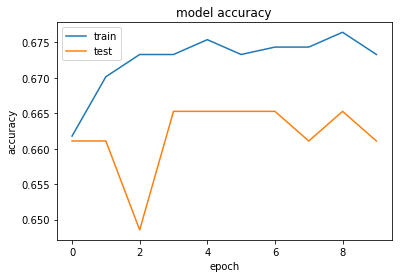

Model 1 : binary_accuracy
binary_accuracy


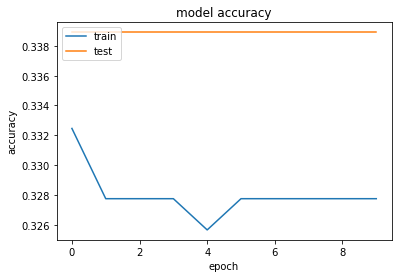

Model 2 : categorical_accuracy
categorical_accuracy


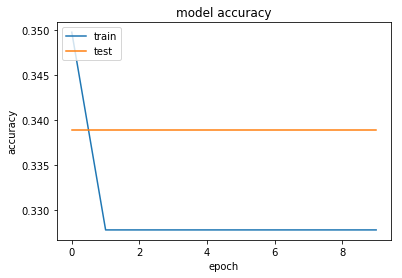

Model 3 : sparse_categorical_accuracy
sparse_categorical_accuracy


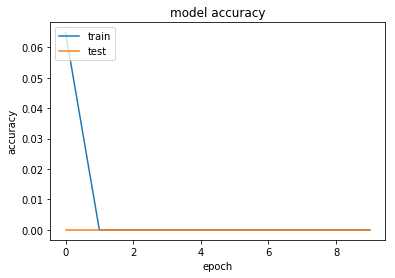

Model 4 : top_k_categorical_accuracy
top_k_categorical_accuracy


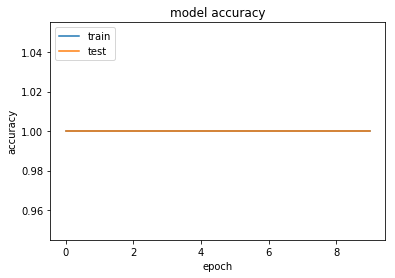

In [49]:
count=0
for i,metric in enumerate(metrics):
    print("Model", count , ":",metric)
    plot_acc(model_list[count], metric)
    count += 1
    plt.show()

In [172]:
for metric in ['acc', binary_accuracy, categorical_accuracy, sparse_categorical_accuracy, top_k_categorical_accuracy]:
model0 = cnn_model()
model0.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[sparse_categorical_accuracy, top_k_categorical_accuracy])
model0.fit(x_train, y_train, validation_split = .2,
               epochs=2, batch_size=64, class_weight=class_weight)


Train on 955 samples, validate on 239 samples
Epoch 1/2
955/955 [==============================] - 14s - loss: 0.6339 - sparse_categorical_accuracy: 0.9822 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.7313 - val_sparse_categorical_accuracy: 1.0000 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/2
955/955 [==============================] - 12s - loss: 0.6220 - sparse_categorical_accuracy: 1.0000 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.6626 - val_sparse_categorical_accuracy: 1.0000 - val_top_k_categorical_accuracy: 1.0000


In [179]:
model0 = cnn_model()
model0.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc', binary_accuracy, categorical_accuracy])
model0.fit(x_train, y_train, validation_split = .2,
               epochs=10, batch_size=64, class_weight=class_weight)

Train on 955 samples, validate on 239 samples
Epoch 1/10
955/955 [==============================] - 14s - loss: 0.6294 - acc: 0.6880 - binary_accuracy: 0.6880 - categorical_accuracy: 0.6880 - val_loss: 0.6699 - val_acc: 0.6234 - val_binary_accuracy: 0.6234 - val_categorical_accuracy: 0.6234
Epoch 2/10
955/955 [==============================] - 12s - loss: 0.6200 - acc: 0.6880 - binary_accuracy: 0.6880 - categorical_accuracy: 0.6880 - val_loss: 0.6608 - val_acc: 0.6234 - val_binary_accuracy: 0.6234 - val_categorical_accuracy: 0.6234
Epoch 3/10
955/955 [==============================] - 14s - loss: 0.6281 - acc: 0.6880 - binary_accuracy: 0.6880 - categorical_accuracy: 0.6880 - val_loss: 0.6612 - val_acc: 0.6234 - val_binary_accuracy: 0.6234 - val_categorical_accuracy: 0.6234
Epoch 4/10
955/955 [==============================] - 13s - loss: 0.6168 - acc: 0.6880 - binary_accuracy: 0.6880 - categorical_accuracy: 0.6880 - val_loss: 0.6591 - val_acc: 0.6234 - val_binary_accuracy: 0.6234 - val

In [177]:
scores = model0.evaluate(x_test,y_test)
print("\n%s: %.2f%%" % (model0.metrics_names[1], scores[1]*100))

298/298 [==============================] - 1s     

sparse_categorical_accuracy: 100.00%


## Fitting with different hyperparameters

In [240]:
def multiple_hyper_train(x_train, y_train, x_test, y_test):
    model_list= []
    for i,loss_func in enumerate(['categorical_crossentropy','binary_crossentropy']):
        for j,optimizer in enumerate(['rmsprop']):
            model = cnn_model()
            model.compile(optimizer=optimizer,loss=loss_func, metrics=[top_k_categorical_accuracy, sparse_categorical_accuracy])
            model.fit(x_train, y_train, validation_split = 0.2, epochs=10, batch_size=128) 
            model_list.append(model)
            scores = model.evaluate(x_test,y_test)
            print('------------------------------------------')
            print(loss_func, "+", optimizer)
            print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
            print('------------------------------------------')
    return model_list

In [241]:
models = multiple_hyper_train(x_train, y_train, x_test, y_test)

Train on 955 samples, validate on 239 samples
Epoch 1/10
955/955 [==============================] - 14s - loss: 4.6406 - top_k_categorical_accuracy: 1.0000 - sparse_categorical_accuracy: 0.9309 - val_loss: 4.8734 - val_top_k_categorical_accuracy: 1.0000 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/10
955/955 [==============================] - 11s - loss: 5.0571 - top_k_categorical_accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.8733 - val_top_k_categorical_accuracy: 1.0000 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/10
955/955 [==============================] - 11s - loss: 5.0537 - top_k_categorical_accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.8733 - val_top_k_categorical_accuracy: 1.0000 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/10
955/955 [==============================] - 12s - loss: 5.0500 - top_k_categorical_accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.8733 - val_top_k_categorical_accuracy: 1.0

## Visualization

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_acc(model, metric):
    #summarize history for accuracy
    print(str(metric))
    plt.plot(model.history.history[str(metric)])
    plt.plot(model.history.history['val_' + str(metric)])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
def plot_loss(model):
    #summarize history for loss
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    


Model 0 : categorical_crossentropy + rmsprop


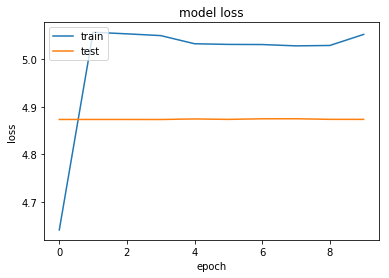

Model 1 : binary_crossentropy + rmsprop


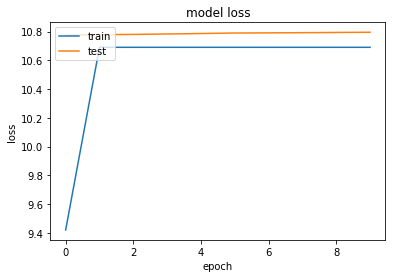

In [255]:
count=0
for i,loss_func in enumerate(['categorical_crossentropy','binary_crossentropy']):
    for j,optimizer in enumerate(['rmsprop']):
        print("Model", count , ":",loss_func,"+", optimizer)
        plot_loss(models[count])
        count += 1
        plt.show()

## K-fold cross validation to handle imbalance classes

In [265]:
from sklearn.model_selection import StratifiedKFold
def kfold_cv(x_train, y, labels):
    # fix random seed for reproducibility
    seed = 7
    np.random.seed(seed)
    #############################################
    # define 10-fold cross validation test harness
    # The folds are made by preserving the percentage of samples for each class.
    #############################################
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    cvscores = []
    models = []

    for train, test in kfold.split(data, y):
        # create model
        model = cnn_model()
        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[top_k_categorical_accuracy])
        # Fit the model
        model.fit(data[train], labels[train], verbose=1, validation_split=.2, 
                                      epochs=10, batch_size=128, class_weight=class_weight)
        models.append(model)
        
        # evaluate the model
        scores = model.evaluate(data[test], labels[test], verbose=1)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
    print("Mean:",np.mean(cvscores), "STD:",np.std(cvscores))
    return (models, cvscores)

In [266]:
k = kfold_cv(data, y, labels)

Train on 953 samples, validate on 239 samples
Epoch 1/10
953/953 [==============================] - 14s - loss: 5.8522 - top_k_categorical_accuracy: 1.0000 - val_loss: 5.2749 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/10
953/953 [==============================] - 11s - loss: 5.1053 - top_k_categorical_accuracy: 1.0000 - val_loss: 5.2772 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/10
953/953 [==============================] - 11s - loss: 5.1096 - top_k_categorical_accuracy: 1.0000 - val_loss: 5.2835 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/10
953/953 [==============================] - 11s - loss: 5.1071 - top_k_categorical_accuracy: 1.0000 - val_loss: 5.2749 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/10
953/953 [==============================] - 11s - loss: 5.0960 - top_k_categorical_accuracy: 1.0000 - val_loss: 5.2757 - val_top_k_categorical_accuracy: 1.0000
Epoch 6/10
953/953 [==============================] - 11s - loss: 5.0926 - top_k_categorical_accuracy: 1

Model 0 : 0 + rmsprop


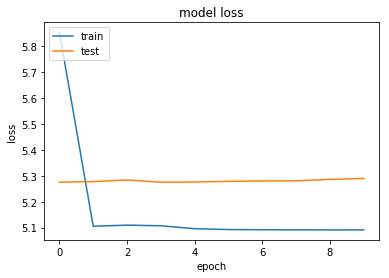

Model 1 : 1 + rmsprop


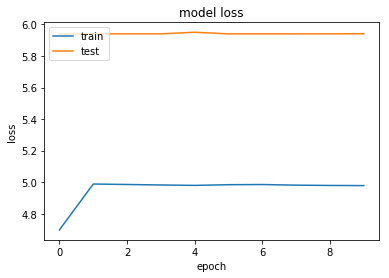

Model 2 : 2 + rmsprop


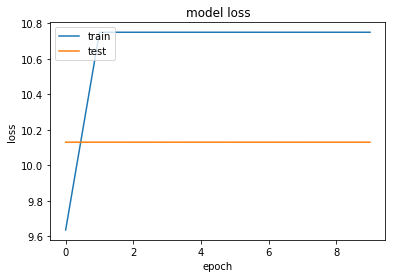

Model 3 : 3 + rmsprop


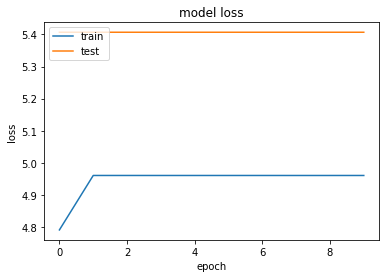

Model 4 : 4 + rmsprop


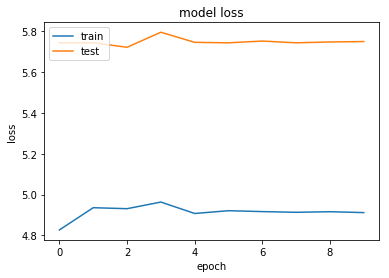

In [269]:
count=0
for i,loss_func in enumerate(range(5)):
    print("Model", count , ":",loss_func,"+", optimizer)
    plot_loss(k[0][count])
    count += 1
    plt.show()

In [268]:
k[0]

## Conclusion:

The goal of the project is aim to show the great performance of using deep learning in text classification for a supervised dataset of TedTalk transcripts whether the speech is from a male voice or female voice. The training/learning is gone through two comparable methodologies which is a baseline model using scikit learn versus a strong deep learning model using keras modules. The evaluation showed that the accuracy for baseline model is about 99.7% while with the right metric evaluation( in this case, it's k-top-categorical-accuracy), deep learning model is able to predict correctly 100%. This shows that deep learning model is really powerful in advanced contexts. 
   

## Q&A

* What was the biggest challenge/obstacle/hurdle?

During the training, the challenges are scattered through each step, the biggest challenge is during the training proccess. Since putting the wrong hyperparameters would yield a significant wrong result, it did take time and tests to investigate the optimized result.

* If you had two more weeks what would you do?

If there are additional time for this project, I would likely to explore with more complex classification rather than just male and female. It can be subject/topic classification such as science, math, environment, english,... .
    
* Does it scale?

Yes, the model is able to be flexible for adjusting size of all keras parameters such as embedding dimension, MAX_SEQUENCE_LENGTH 

* How would you turn your project in a data product?

To do so, the input data must have to be formatted in same way with the Tedtalk transcript document. The input data will then be able to preprocessed. All parameters in keras would have been set to be bigger or smaller upon the size of dataset or user's choice.

* Why does your deep learning model beat your baseline?

Deep learning is able to adjust weight by using different optimizers, by doing so, accuracy is slightly improved but it will results in high tradeoff with loss.

* What are the tradeoffs between your baseline and your deep learning model? Would you put your deep learning model into production over your baseline? Why or why not?

Even though multiple loss functions have been tested, the training still shows high loss tradeoff with accuracy. Because of this, the model maybe not be considered as a perfect model for data production.

* What evidence can you provide that your model has generalized correctly?

Evaluation for test data always reach 100% for every repeat test.

* Are your results significant?
Yes, they are.

* What hyperparameters mattered? Which didn't?

Metrics is the most important hyperparameter among others. For the imbalance dataset, the wrong metrics had leaded to the significant incorrect predictions.

* Why did or didn't you use accuracy as your evaluation metric?
I start by testing with different metrics and it appears that k-top-categorical-accuracy showed the top result. Its algorithm works by calculate how often a target class is within the top-k predictions.